# Load CoGo Status Stream files

In [143]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [144]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [145]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [146]:
def load_status_data(program_code = 'babs'):

    print('Loading %s Status Data...' % program_code.upper())

    try:
        file_path_slug = '../streamed_data/%s/*station_status*.csv' % program_code

        # glob all files
        file_list = glob(file_path_slug)

        status_import = pd.DataFrame()
        status_import_chunks = []

        counter = 1

        # load data from each file
        for file in file_list:

            chunksize = 10000

            # import file in chunks
            for chunk in pd.read_csv(file, chunksize=chunksize, iterator=True):

                # append chunk to chunks list
                status_import_chunks.append(chunk)

            if counter == 1 or counter % math.ceil(len(file_list)/10) == 0 or counter == len(file_list):
                print('\tFinished file! (%d of %d)' % (counter, len(file_list)))        

            counter += 1

        status_import = pd.concat(status_import_chunks)
        print('Data Loaded Successfully!\n')

    except:
        print('oops... something went wrong importing the data :(')
    
    status_import.rename(columns={'last_reported' : 'time',
                                     'eightd_has_available_keys' : 'has_available_keys',
                                     'is_installed' : 'is_installed',
                                     'is_renting' : 'is_renting',
                                     'is_returning' : 'is_returning',
                                     'num_bikes_available' : 'bikes_available',
                                     'num_bikes_disabled' : 'bikes_disabled',
                                     'num_docks_available' : 'docks_available',
                                     'num_docks_disabled' : 'docks_disabled',
                                     'station_id' : 'station_id'}, inplace=True)

    status_import['time'] = pd.to_datetime(status_import['time'], format="%Y-%m-%d %H:%M:%S")
    
    
    change_date = pd.Timestamp('2017-11-10')
    change_date = pd.Timestamp('2017-11-10 16:00')
    
    status_import = status_import[status_import.time >= change_date]




    status_import.sort_values('time', inplace=True)
    status_import.drop_duplicates(inplace=True)

    
    status_import['bike_change'] = status_import['bikes_available'].diff()
    status_import['bike_change'] = status_import['bike_change'].apply(lambda x: 1 if x > 0 else 0)
    
    status_import['dock_change'] = status_import['docks_available'].diff()
    status_import['dock_change'] = status_import['dock_change'].apply(lambda x: 1 if x > 0 else 0)
    
    status_import.reset_index(inplace=True, drop=True)
    status_import.head()
    
    return status_import

In [148]:
cogo_status_data = load_status_data(program_code='cogo')
babs_status_data = load_status_data(program_code='babs')
citi_status_data = load_status_data(program_code='citi')
hubway_status_data = load_status_data(program_code='hubway')
cabi_status_data = load_status_data(program_code='cabi')
divvy_status_data = load_status_data(program_code='divvy')

Loading COGO Status Data...
	Finished file! (1 of 2)
	Finished file! (2 of 2)
Data Loaded Successfully!

Loading BABS Status Data...
	Finished file! (1 of 2)
	Finished file! (2 of 2)
Data Loaded Successfully!

Loading CITI Status Data...
	Finished file! (1 of 2)
	Finished file! (2 of 2)
Data Loaded Successfully!

Loading HUBWAY Status Data...
	Finished file! (1 of 2)
	Finished file! (2 of 2)
Data Loaded Successfully!

Loading CABI Status Data...
	Finished file! (1 of 2)
	Finished file! (2 of 2)
Data Loaded Successfully!

Loading DIVVY Status Data...
	Finished file! (1 of 2)
	Finished file! (2 of 2)
Data Loaded Successfully!



In [149]:
def show_station(df, id, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].cumsum().plot(color=color, figsize=(24,3))
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()

In [150]:
def plot_hourly_usage(df, title='CoGo', color='r'):
    x_ticks = sorted(pd.unique(df.time.dt.hour))
    df_data = df[df.bike_change != 0]
    df_data.reset_index(inplace=True, drop=True)
    df_status_change = df_data.groupby([df_data.time.dt.hour])['station_id'].count()

    plt.subplots(figsize=(24,6))
    ax = sns.barplot(x = df_status_change.index , y = df_status_change, color=color, alpha = 0.25, label=title)
    ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
#     ax.set_xticks(x_ticks)
    plt.legend()
    plt.show()

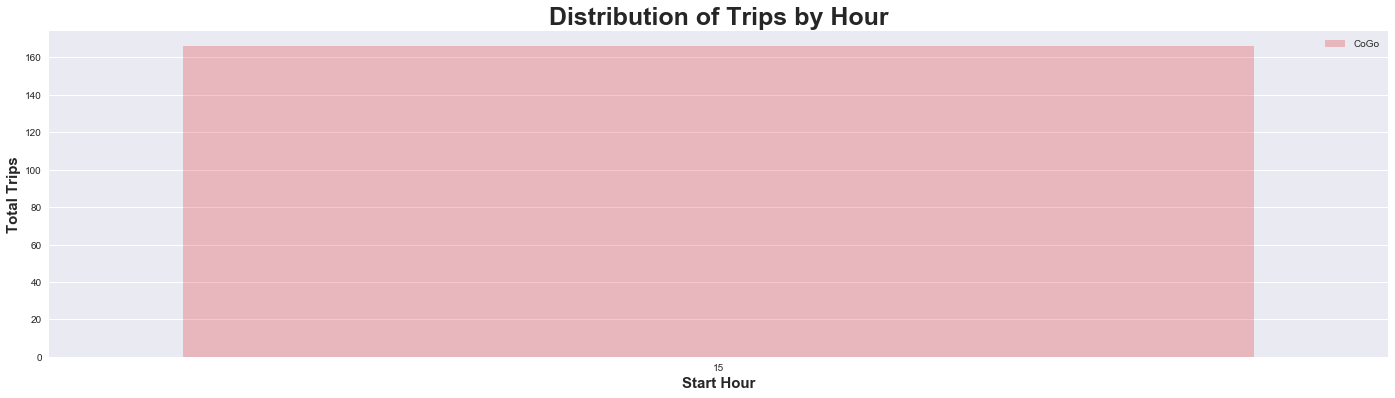

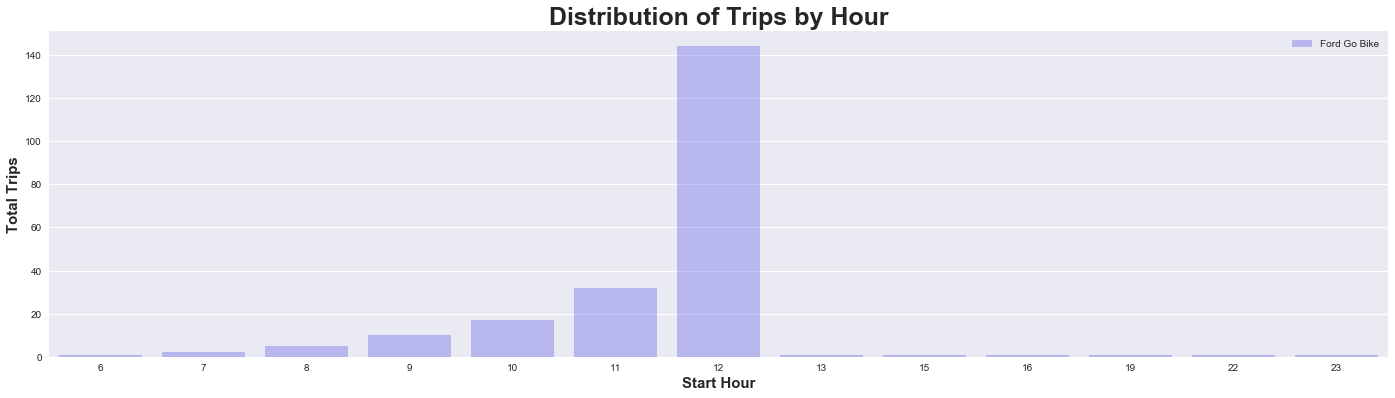

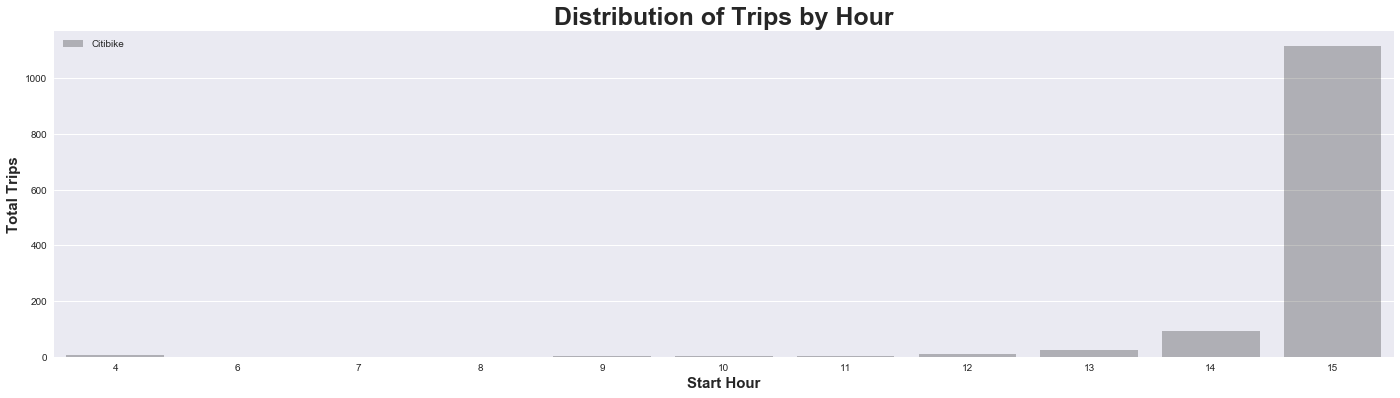

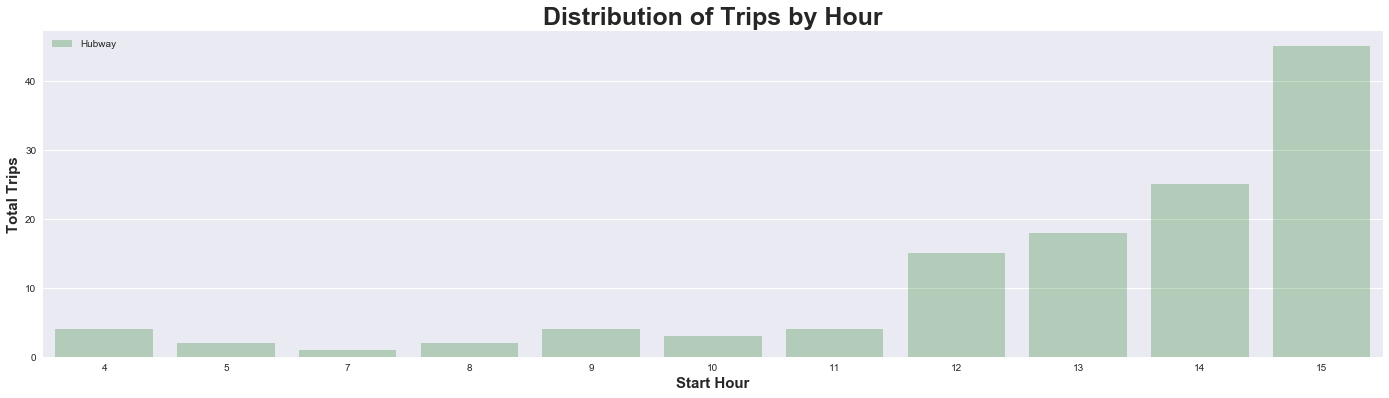

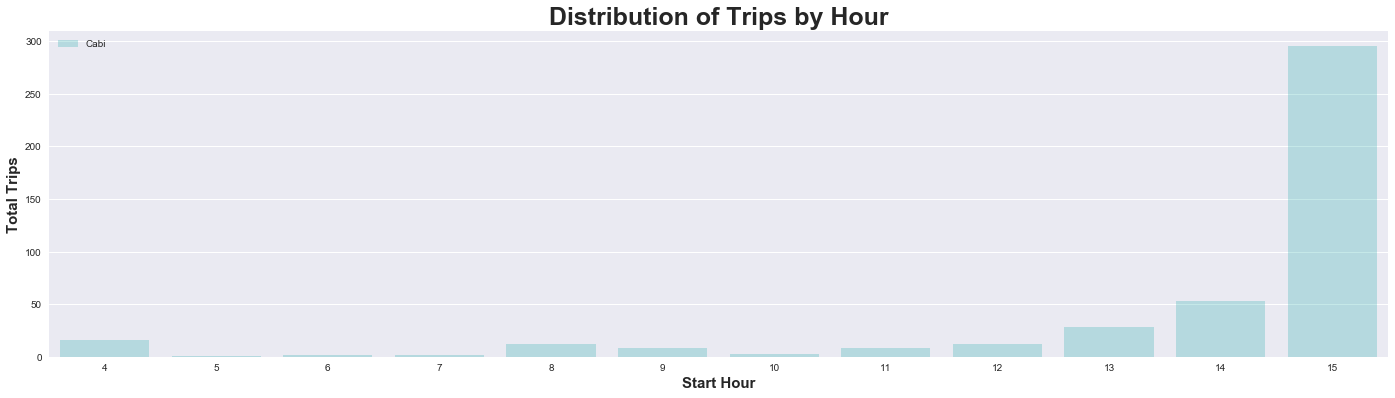

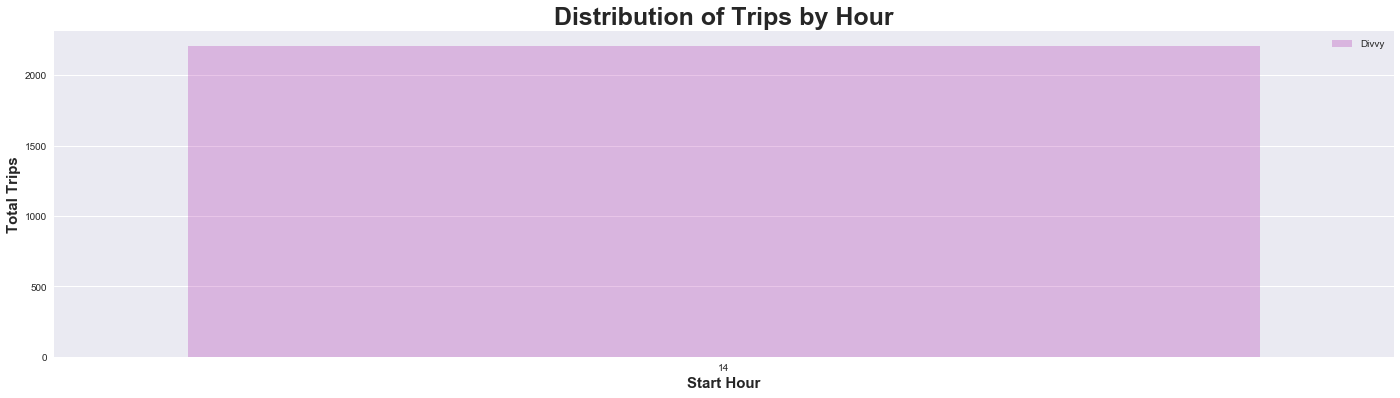

In [151]:
plot_hourly_usage(cogo_status_data, title='CoGo', color='r')
plot_hourly_usage(babs_status_data, title='Ford Go Bike', color='b')
plot_hourly_usage(citi_status_data, title='Citibike', color='k')
plot_hourly_usage(hubway_status_data, title='Hubway', color='g')
plot_hourly_usage(cabi_status_data, title='Cabi', color='c')
plot_hourly_usage(divvy_status_data, title='Divvy', color='m')

In [152]:
def resample_status(df, interval='5T', verbose=False):
    if verbose:
        print('[%s] Resampling on interval' % datetime.datetime.now().time())
    df_resampled = df.copy()
    df_resampled.set_index(['station_id', 'time'], inplace=True)

    # resample on 5 minute interval mean
    df_resampled = df_resampled.groupby([pd.Grouper(level=0), pd.Grouper(freq=interval, level=-1)]).mean()
    df_resampled.reset_index(inplace=True)
    
    if verbose:
        print('[%s] Complete' % datetime.datetime.now().time())
    return df_resampled

In [154]:
print('\nTotal CoGo Stations:\t\t\t%s' % len(pd.unique(cogo_status_data.station_id)))
print('Total CoGo Trips:\t\t\t%s' % cogo_status_data.groupby('station_id').bike_change.sum().sum())

print('\nTotal Ford Go Bike Stations:\t\t%s' % len(pd.unique(babs_status_data.station_id)))
print('Total Ford Go Bike Trips:\t\t%s' % babs_status_data.groupby('station_id').bike_change.sum().sum())

print('\nTotal Citibike Stations:\t\t%s' % len(pd.unique(citi_status_data.station_id)))
print('Total Citibike Trips:\t\t\t%s' % citi_status_data.groupby('station_id').bike_change.sum().sum())

print('\nTotal Divvy Stations:\t\t\t%s' % len(pd.unique(divvy_status_data.station_id)))
print('Total Divvy Trips:\t\t\t%s' % divvy_status_data.groupby('station_id').bike_change.sum().sum())

print('\nTotal Hubway Stations:\t\t\t%s' % len(pd.unique(hubway_status_data.station_id)))
print('Total Hubway Trips:\t\t\t%s' % hubway_status_data.groupby('station_id').bike_change.sum().sum())

print('\nTotal Capital City Stations:\t\t%s' % len(pd.unique(cabi_status_data.station_id)))
print('Total Capital City Trips:\t\t%s' % cabi_status_data.groupby('station_id').bike_change.sum().sum())


Total CoGo Stations:			46
Total CoGo Trips:			166

Total Ford Go Bike Stations:		245
Total Ford Go Bike Trips:		217

Total Citibike Stations:		777
Total Citibike Trips:			1261

Total Divvy Stations:			582
Total Divvy Trips:			2208

Total Hubway Stations:			193
Total Hubway Trips:			123

Total Capital City Stations:		485
Total Capital City Trips:		440


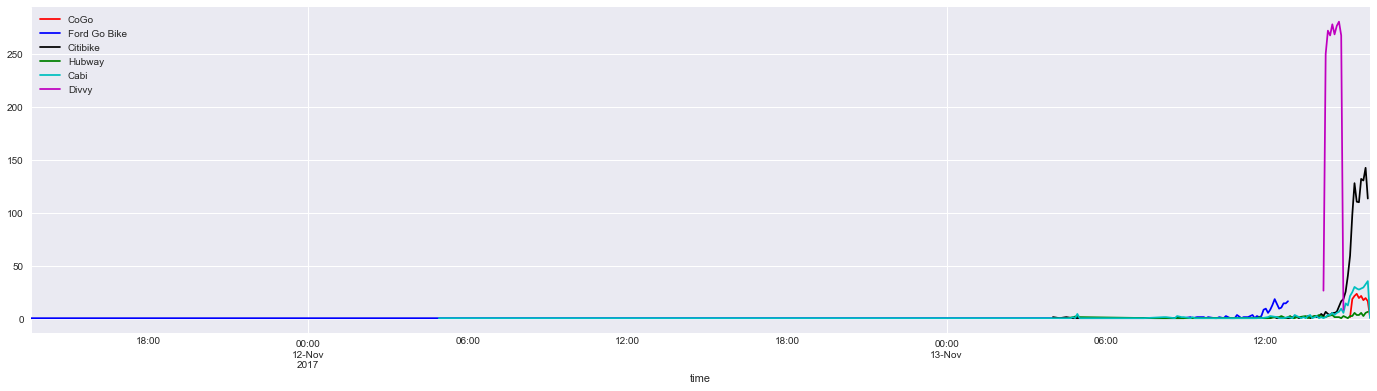

In [155]:
cogo_status_data_resample = resample_status(cogo_status_data, interval='5T')#                  label='CoGo', color='r')
babs_status_data_resample = resample_status(babs_status_data, interval='5T')#                  label='Ford Go Bike', color='b')
citi_status_data_resample = resample_status(citi_status_data, interval='5T')#                  label='Citibike', color='k')
hubway_status_data_resample = resample_status(hubway_status_data, interval='5T')#                  label='Hubway', color='g')
cabi_status_data_resample = resample_status(cabi_status_data, interval='5T')#                  label='Cabi', color='c')
divvy_status_data_resample = resample_status(divvy_status_data, interval='5T')#                  label='Divvy', color='m')

ax = cogo_status_data_resample[cogo_status_data_resample.bike_change > 0].groupby('time').bike_change.sum().plot(color='r', figsize=(24, 6), label='CoGo')
babs_status_data_resample[babs_status_data_resample.bike_change > 0].groupby('time').bike_change.sum().plot(color='b', ax=ax, label='Ford Go Bike')
citi_status_data_resample[citi_status_data_resample.bike_change > 0].groupby('time').bike_change.sum().plot(color='k', ax=ax, label='Citibike')
hubway_status_data_resample[hubway_status_data_resample.bike_change > 0].groupby('time').bike_change.sum().plot(color='g', ax=ax, label='Hubway')
cabi_status_data_resample[cabi_status_data_resample.bike_change > 0].groupby('time').bike_change.sum().plot(color='c', ax=ax, label='Cabi')
divvy_status_data_resample[divvy_status_data_resample.bike_change > 0].groupby('time').bike_change.sum().plot(color='m', ax=ax, label='Divvy')


ax.legend(['CoGo','Ford Go Bike','Citibike','Hubway','Cabi','Divvy'], loc=2)
plt.show()

In [156]:
def trips_by_station(df, title):
    print('\n%s' % title)
    print('-' * 80)
    for i in sorted(pd.unique(df.station_id)):
        print('Total %s Trips from Station %s:\t%s' % (title, i, df[df.station_id == i].bike_change.sum().sum()))

In [157]:
trips_by_station(cogo_status_data, 'cogo')
trips_by_station(babs_status_data, 'babs')
trips_by_station(citi_status_data, 'citi')
trips_by_station(hubway_status_data, 'hubway')
trips_by_station(cabi_status_data, 'cabi')
trips_by_station(divvy_status_data, 'divvy')


cogo
--------------------------------------------------------------------------------
Total cogo Trips from Station 1:	8
Total cogo Trips from Station 2:	5
Total cogo Trips from Station 3:	0
Total cogo Trips from Station 4:	5
Total cogo Trips from Station 5:	3
Total cogo Trips from Station 6:	6
Total cogo Trips from Station 7:	8
Total cogo Trips from Station 8:	3
Total cogo Trips from Station 9:	0
Total cogo Trips from Station 10:	3
Total cogo Trips from Station 11:	8
Total cogo Trips from Station 12:	7
Total cogo Trips from Station 13:	8
Total cogo Trips from Station 14:	8
Total cogo Trips from Station 15:	7
Total cogo Trips from Station 16:	4
Total cogo Trips from Station 17:	0
Total cogo Trips from Station 18:	0
Total cogo Trips from Station 19:	0
Total cogo Trips from Station 20:	2
Total cogo Trips from Station 21:	7
Total cogo Trips from Station 22:	8
Total cogo Trips from Station 23:	5
Total cogo Trips from Station 24:	7
Total cogo Trips from Station 25:	0
Total cogo Trips from 

Total babs Trips from Station 276:	1
Total babs Trips from Station 277:	0
Total babs Trips from Station 278:	3
Total babs Trips from Station 279:	0
Total babs Trips from Station 280:	1
Total babs Trips from Station 281:	1
Total babs Trips from Station 282:	0
Total babs Trips from Station 284:	1
Total babs Trips from Station 285:	0
Total babs Trips from Station 286:	1
Total babs Trips from Station 287:	1
Total babs Trips from Station 288:	0
Total babs Trips from Station 289:	1
Total babs Trips from Station 290:	0
Total babs Trips from Station 291:	1
Total babs Trips from Station 295:	0
Total babs Trips from Station 296:	0
Total babs Trips from Station 297:	0
Total babs Trips from Station 299:	0
Total babs Trips from Station 301:	0
Total babs Trips from Station 304:	0
Total babs Trips from Station 305:	0
Total babs Trips from Station 306:	1
Total babs Trips from Station 307:	0
Total babs Trips from Station 308:	0
Total babs Trips from Station 309:	0
Total babs Trips from Station 310:	1
T

Total citi Trips from Station 3050:	1
Total citi Trips from Station 3052:	0
Total citi Trips from Station 3053:	0
Total citi Trips from Station 3054:	0
Total citi Trips from Station 3055:	1
Total citi Trips from Station 3056:	0
Total citi Trips from Station 3057:	1
Total citi Trips from Station 3058:	0
Total citi Trips from Station 3059:	0
Total citi Trips from Station 3060:	0
Total citi Trips from Station 3061:	0
Total citi Trips from Station 3062:	0
Total citi Trips from Station 3063:	0
Total citi Trips from Station 3064:	1
Total citi Trips from Station 3065:	0
Total citi Trips from Station 3066:	1
Total citi Trips from Station 3067:	1
Total citi Trips from Station 3068:	1
Total citi Trips from Station 3069:	0
Total citi Trips from Station 3070:	0
Total citi Trips from Station 3071:	0
Total citi Trips from Station 3072:	0
Total citi Trips from Station 3073:	1
Total citi Trips from Station 3074:	0
Total citi Trips from Station 3075:	0
Total citi Trips from Station 3076:	0
Total citi T

Total cabi Trips from Station 111:	0
Total cabi Trips from Station 112:	2
Total cabi Trips from Station 113:	5
Total cabi Trips from Station 114:	5
Total cabi Trips from Station 115:	0
Total cabi Trips from Station 116:	0
Total cabi Trips from Station 117:	1
Total cabi Trips from Station 118:	0
Total cabi Trips from Station 124:	0
Total cabi Trips from Station 125:	2
Total cabi Trips from Station 126:	2
Total cabi Trips from Station 127:	1
Total cabi Trips from Station 128:	3
Total cabi Trips from Station 129:	0
Total cabi Trips from Station 130:	0
Total cabi Trips from Station 131:	0
Total cabi Trips from Station 132:	0
Total cabi Trips from Station 133:	1
Total cabi Trips from Station 134:	0
Total cabi Trips from Station 135:	2
Total cabi Trips from Station 136:	2
Total cabi Trips from Station 137:	1
Total cabi Trips from Station 138:	0
Total cabi Trips from Station 139:	1
Total cabi Trips from Station 140:	1
Total cabi Trips from Station 141:	2
Total cabi Trips from Station 142:	5
T